<a href="https://colab.research.google.com/github/safanisna/datascientest-ocr/blob/main/DataScientest_Safan_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets
!pip install opencv-python
!pip install pytesseract
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 71.2 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.2/619.2 KB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.68
    Uninstalling opencv-python-headless-4.7.0.68:
      Successfully uninstalled opencv-python-headless-4.7.0.68


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import opendatasets as od
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib import image as mpimg

Downloading datasets from kaggle using opendatasets (need kaggle account to provide kaggle credentials)

In [3]:
od.download('https://www.kaggle.com/datasets/manishthem/text-extraction-for-ocr')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: safanisna
Your Kaggle Key: ··········


100%|██████████| 34.1M/34.1M [00:00<00:00, 126MB/s]


# Datasets
Below are the given description regarding the dataset.

> ### About Dataset
> #### Context
Typical NER will identify various entities in the text but not every name come with proper context. The data set provides structured data in the XML format and requires its users to extract various entities.
> #### Content
The data set consist of XML files and images. The XML files contain the extracted data from the image of the invoices, name of text and XML file is kept the same for clarity. Users of the dataset should extract entities like invoice no, invoice data, company name (invoice from company1 to company2/person), telephone number of the company, address e.t.c
> #### Acknowledgements
We wouldn't be here without the help of others. If you owe any attributions or thanks, include them here along with any citations of past research.
> #### Inspiration
Challenges: <br>
Invoices data contains tabular data, which is challenging to deal with. Design a methodology to extract information from tabular data.
Due to obvious reasons, certain numbers in XML are erroneous for eg, '0' replaced by 'O'.

## Understanding the Data
Find dataset using `os` package to see the completeness of datasets.

In [7]:
import os
path_ = '/content/text-extraction-for-ocr/ImageAndXML_Data'

In [8]:
# dataset path

filepath = path_ + '/'
del path_

### Completeness checking
To check whether we have all the neccessary files

In [9]:
# counting number of files inside the dataset
# counting the completeness of each image file

nfiles = 0

# Initializing filename, gt, ocr file as a checklist

tifs, gts, ocrs, oths = [], [], [], []


for i, file in enumerate(os.listdir(filepath)):
    nfiles += 1
    if i < 10:
        print(os.path.join('/', file))
    if file.endswith('.tif'):
        tifs.append(file)
    elif file.endswith('_gt.xml'):
        gts.append(file)
    elif file.endswith('_ocr.xml'):
        ocrs.append(file)
    else:
        oths.append(file)

print('\n')
print('There are total', nfiles, 'number of files in the data')

/00043445_00043449_ocr.xml
/2072957830.tif
/508560943+-0943_ocr.xml
/ti10160632_ocr.xml
/91575506_5509_gt.xml
/518253587+-3590.tif
/10399225_ocr.xml
/2029370804_gt.xml
/526450292+-0292_gt.xml
/ti17120370_ocr.xml


There are total 1560 number of files in the data


If we look at the filename above. All filename are assumed to be formatted this way:
1. xx.tif as the image
2. xx_gt.xml as the 1st xml
3. xx_ocr.xml as the 2nd xml

The xx will then called as `image_id`

Referring to the description: <br> <b> The XML files contain the extracted data from the image of the invoices, name of text and XML file is kept the same for clarity. </b>

In [10]:
print('#file formatted .tif:', len(tifs))
print('#file formatted _gt.xml:', len(gts))
print('#file formatted _ocr.xml:', len(ocrs))

#file formatted .tif: 520
#file formatted _gt.xml: 520
#file formatted _ocr.xml: 520


In [11]:
all_files = tifs + gts + ocrs
ids = [i.replace('.tif', '').replace('_gt.xml','').replace('_ocr.xml','') for i in all_files]
ids = list(set(ids))

print('#image id:', len(ids))

#image id: 520


In [12]:
# file completeness check

a = [0] * len(ids)
tifs_ = a.copy()
gts_ = a.copy()
ocrs_ = a.copy()

for i,id_ in enumerate(ids):
    _tif = str(id_) + '.tif'
    _gt = str(id_) + '_gt.xml'
    _ocr = str(id_) + '_ocr.xml'
    if i < 10:
        if _tif in tifs:
            tifs_[i] = 1
        if _gt in gts:
            gts_[i] = 1
        if _ocr in ocrs:
            ocrs_[i] = 1

In [13]:
ids, tifs, gts, ocrs = sorted(ids), sorted(tifs), sorted(gts), sorted(ocrs)

df1 = pd.DataFrame({'id': ids, '.tif':tifs, '_gt.xml':gts, '_ocr.xml':ocrs})
df1.tail()

,id,.tif,_gt.xml,_ocr.xml
515,ti17120992,ti17120992.tif,ti17120992_gt.xml,ti17120992_ocr.xml
516,ti31149327_9330,ti31149327_9330.tif,ti31149327_9330_gt.xml,ti31149327_9330_ocr.xml
517,ti31689113,ti31689113.tif,ti31689113_gt.xml,ti31689113_ocr.xml
518,ti31689150,ti31689150.tif,ti31689150_gt.xml,ti31689150_ocr.xml
519,tob02910.64,tob02910.64.tif,tob02910.64_gt.xml,tob02910.64_ocr.xml


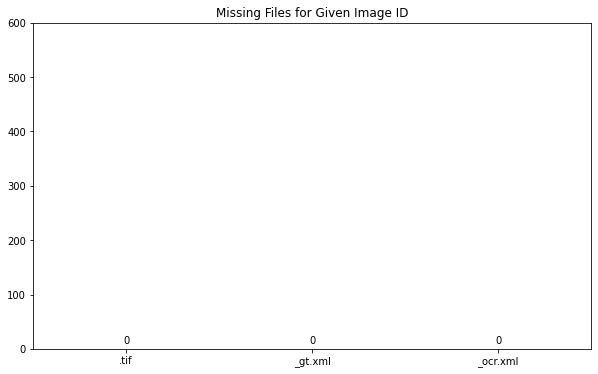

In [14]:
nrow = df1.shape[0]
ct = df1.isna().sum()[1:]

f, ax = plt.subplots(1,1, figsize=(10, 6))
ct.plot(kind='bar', ax=ax)
ax.set_ylim([0, 600])
ax.set_xticklabels(ct.index, rotation = 0)
ax.set_title('Missing Files for Given Image ID')

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
# f, ax = plt.gcf(), plt.

<b> From the dataframe above, it's safe to conclude that each image_id has `.tif`, `_gt.xml`, and `_ocr.xml` files. </b>

### What is the data look like?
See what we are dealing with in this document extraction dataset

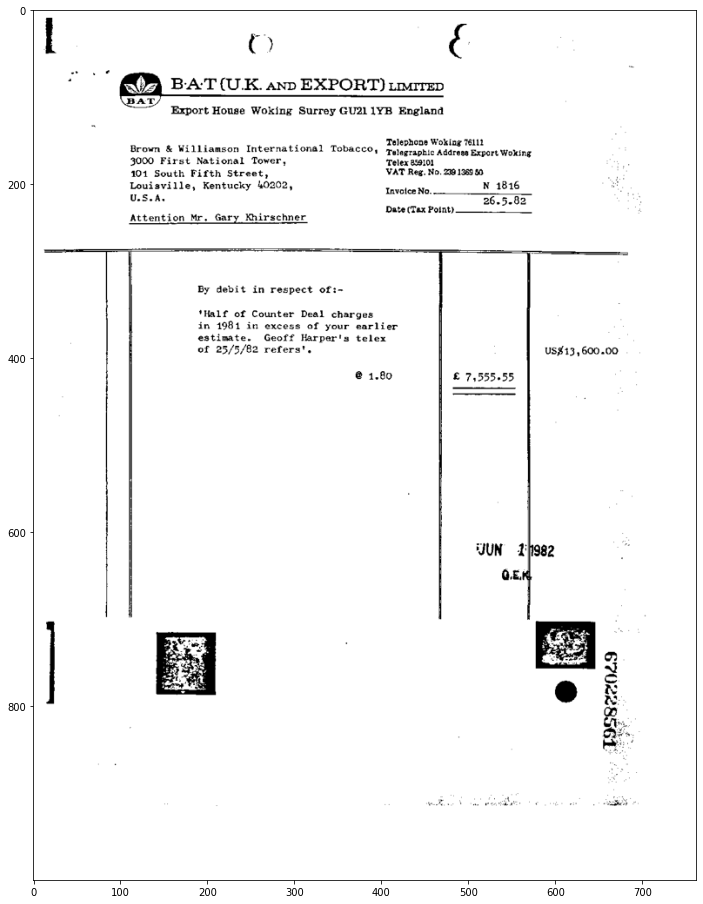

In [15]:
fn = '0000223278.tif'
fn = filepath + fn
image = mpimg.imread(fn)
plt.imshow(image, cmap='gray')
f = plt.gcf()
f.set_size_inches(24.5, 16)
plt.show()

In [16]:
img_shape=[]
img_size=[]

for i in tifs:
    image = mpimg.imread(filepath +  i)
    img_shape.append(image.shape)
    img_size.append(image.size)

In [17]:
df_list = list(zip(ids,tifs,ocrs,gts,img_size,img_shape))
df = pd.DataFrame(df_list, columns=['ids','tif','ocr','gt','size','shape'])
df.head()

,ids,tif,ocr,gt,size,shape
0,0000223278,0000223278.tif,0000223278_ocr.xml,0000223278_gt.xml,762000,"(1000, 762)"
1,0001136521,0001136521.tif,0001136521_ocr.xml,0001136521_gt.xml,762000,"(1000, 762)"
2,0001139626,0001139626.tif,0001139626_ocr.xml,0001139626_gt.xml,762000,"(1000, 762)"
3,0001139716,0001139716.tif,0001139716_ocr.xml,0001139716_gt.xml,762000,"(1000, 762)"
4,0001144288,0001144288.tif,0001144288_ocr.xml,0001144288_gt.xml,762000,"(1000, 762)"


In [18]:
df['height'] = df['shape'].apply(lambda x: x[0])
df['width'] = df['shape'].apply(lambda x: x[1])

df.head()

,ids,tif,ocr,gt,size,shape,height,width
0,0000223278,0000223278.tif,0000223278_ocr.xml,0000223278_gt.xml,762000,"(1000, 762)",1000,762
1,0001136521,0001136521.tif,0001136521_ocr.xml,0001136521_gt.xml,762000,"(1000, 762)",1000,762
2,0001139626,0001139626.tif,0001139626_ocr.xml,0001139626_gt.xml,762000,"(1000, 762)",1000,762
3,0001139716,0001139716.tif,0001139716_ocr.xml,0001139716_gt.xml,762000,"(1000, 762)",1000,762
4,0001144288,0001144288.tif,0001144288_ocr.xml,0001144288_gt.xml,762000,"(1000, 762)",1000,762


In [19]:
df.columns

Index(['ids', 'tif', 'ocr', 'gt', 'size', 'shape', 'height', 'width'], dtype='object')

Text(0.5, 1.0, 'Width of the Documents')

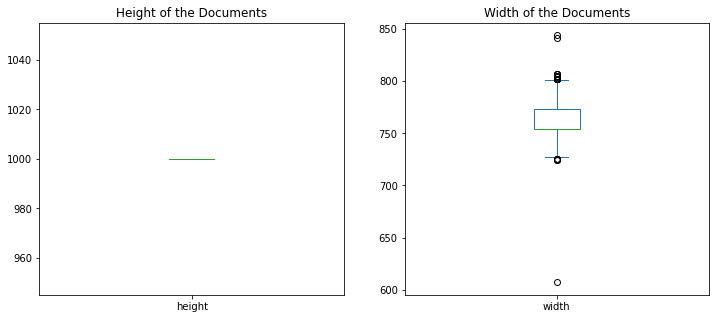

In [20]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
df['height'].plot(kind='box', ax=ax[0])
df['width'].plot(kind='box', ax=ax[1])
ax[0].set_title('Height of the Documents')
ax[1].set_title('Width of the Documents')

From the graph above, we can see that the image documents dataset have standard length of 1000 px and variative width ranging from 600 - 850 px.

### Read the Image and XML data
These code will see what kind of data provided under .xml format 


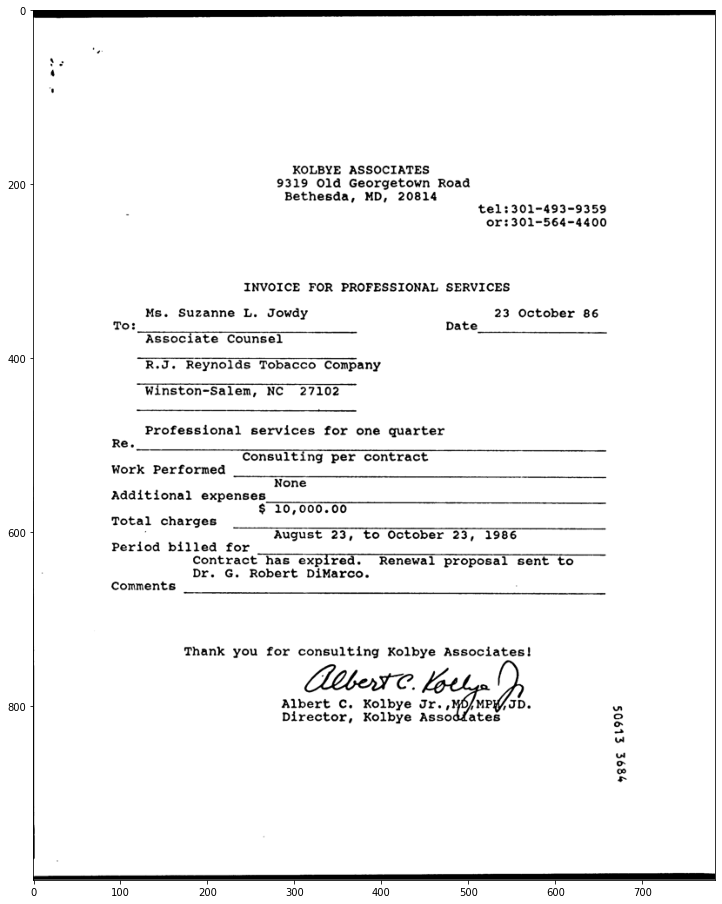

In [21]:
fn = '506133684.tif'
fn = filepath + fn
image = mpimg.imread(fn)
plt.imshow(image, cmap='gray')
f = plt.gcf()
f.set_size_inches(24.5, 16)
plt.show()

In [22]:
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET

In [23]:
fn = '506133684_gt.xml'
fn = filepath + fn

with open(fn, 'r') as f:
  _gt = f.read()

gt_data = BeautifulSoup(_gt, 'xml')
print(gt_data.prettify())

<?xml version="1.0" encoding="utf-8"?>
<PcGts xmlns:="http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15" xmlns:ns2="http://searchink.com/xml/frankstahlapi/1.0">
 <Metadata>
  <Creator>
   system
  </Creator>
  <Created>
   2019-01-25T17:41:42.473+01:00
  </Created>
  <LastChange>
   2019-02-02T02:57:27Z
  </LastChange>
 </Metadata>
 <Property key="customer" value="actuallCustomerName"/>
 <Property key="offer"/>
 <Property key="uuid" value="9242e299-d76f-45ea-8bf3-a6fbbcc9aeab"/>
 <Property key="fileName" value="506133684.pdf"/>
 <Property key="type" value="digital"/>
 <Page imageFilename="506133684.tif" imageHeight="1000" imageWidth="784">
  <TextRegion id="page1_pos1">
   <Property key="entity" value="supplier"/>
   <Coords points="272.956,166.572 669.373,166.572 669.373,257.595 272.956,257.595"/>
  </TextRegion>
  <TextRegion id="page1_pos2">
   <Property key="entity" value="other"/>
   <Coords points="233.434,303.106 556.795,303.106 556.795,325.861 233.434,325.861"/>
 

In [24]:
fn = '506133684_ocr.xml'
fn = filepath + fn

with open(fn, 'r') as f:
  _ocr = f.read()

ocr_data = BeautifulSoup(_ocr, 'xml')
print(ocr_data.prettify())

<?xml version="1.0" encoding="utf-8"?>
<PcGts xmlns:="http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15">
 <Metadata>
  <Creator>
   ABBYY FineReader Engine 11 + alto2page.xslt 2018.11.09
  </Creator>
  <Created>
   2019-01-23T00:00:00
  </Created>
  <LastChange>
   2019-01-23T00:00:00
  </LastChange>
 </Metadata>
 <Page imageFilename="506133684.tif" imageHeight="1000" imageWidth="784">
  <TextRegion id="Page1_TopMargin">
   <Property key="Margin" value="Top"/>
   <Coords points="0,0 784,0 784,178 0,178"/>
  </TextRegion>
  <TextRegion id="Page1_LeftMargin">
   <Property key="Margin" value="Left"/>
   <Coords points="0,178 89,178 89,821 0,821"/>
  </TextRegion>
  <TextRegion id="Page1_RightMargin">
   <Property key="Margin" value="Right"/>
   <Coords points="660,178 784,178 784,1000 660,1000"/>
  </TextRegion>
  <TextRegion id="Page1_Block1">
   <Property key="language" value="en-US"/>
   <Coords points="666,799 683,799 683,888 666,888"/>
   <TextLine id="Page1_Block1_l1"

We can see that the XML file has pieces of information that we an parse using XML parser

## Preprocess the Data
Perform a preprocessing activities to prepare the image data. <br>
Source: [Pre-Processing in OCR!!!](https://towardsdatascience.com/pre-processing-in-ocr-fc231c6035a7)

In [25]:
import cv2
import easyocr

In [26]:
# add folder temp as a saved image from preprocessing steps
temp_path = filepath + 'temp'
if not os.path.exists(temp_path):
    os.makedirs(temp_path)
temp_path = temp_path + '/'

In [27]:
# trying to preprocess just a fraction of all the image dataset

dfs = df.sample(n=50, random_state=70).reset_index(drop=True)
dfs.head()

,ids,tif,ocr,gt,size,shape,height,width
0,ti16310260,ti16310260.tif,ti16310260_ocr.xml,ti16310260_gt.xml,754000,"(1000, 754)",1000,754
1,2028726871,2028726871.tif,2028726871_ocr.xml,2028726871_gt.xml,777000,"(1000, 777)",1000,777
2,2070424009,2070424009.tif,2070424009_ocr.xml,2070424009_gt.xml,754000,"(1000, 754)",1000,754
3,ti15358056_8057,ti15358056_8057.tif,ti15358056_8057_ocr.xml,ti15358056_8057_gt.xml,754000,"(1000, 754)",1000,754
4,80233633,80233633.tif,80233633_ocr.xml,80233633_gt.xml,754000,"(1000, 754)",1000,754


In [28]:
reader = easyocr.Reader(['en'])
fn_ = 'ti15358056_8057.tif'
img_ = mpimg.imread(filepath + fn_)

result = reader.readtext(img_)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [30]:
result

[([[222, 155], [498, 155], [498, 186], [222, 186]],
  'P.JMiller Law Offices, P.A',
  0.719257375004637),
 ([[315, 191], [413, 191], [413, 209], [315, 209]],
  'Attn: Accounting',
  0.5734687439343671),
 ([[325, 209], [405, 209], [405, 223], [325, 223]],
  'P.0. Box [46',
  0.31130529667150586),
 ([[297, 223], [433, 223], [433, 239], [297, 239]],
  'Baldwin WI 54002-0146',
  0.6386997025938422),
 ([[543, 241], [643, 241], [643, 257], [543, 257]],
  '715-684-4344 WI',
  0.7324862021382061),
 ([[91, 263], [209, 263], [209, 277], [91, 277]],
  'Invoice submitted to:',
  0.3990878849872457),
 ([[543, 259], [647, 259], [647, 275], [543, 275]],
  '612-222-3949 MN',
  0.8986658884091313),
 ([[91, 287], [299, 287], [299, 303], [91, 303]],
  'Tobacco Litigation Liaison Counsel',
  0.8677963101001203),
 ([[91, 301], [321, 301], [321, 319], [91, 319]],
  'ROBINS, KAPLAN, MILLER & CIREST:',
  0.46587124337549857),
 ([[93, 321], [123, 321], [123, 333], [93, 333]], 'Attn:', 0.927409067044179),
 ([[1

In [31]:
result[0]

([[222, 155], [498, 155], [498, 186], [222, 186]],
 'P.JMiller Law Offices, P.A',
 0.719257375004637)

In [32]:
def show_image(filename, path=filepath, fig_size=(24.5, 16)):
  fn = filepath + filename
  image = mpimg.imread(fn)
  plt.imshow(image, cmap='gray')
  f = plt.gcf()
  f.set_size_inches(fig_size)
  plt.show()
  return None

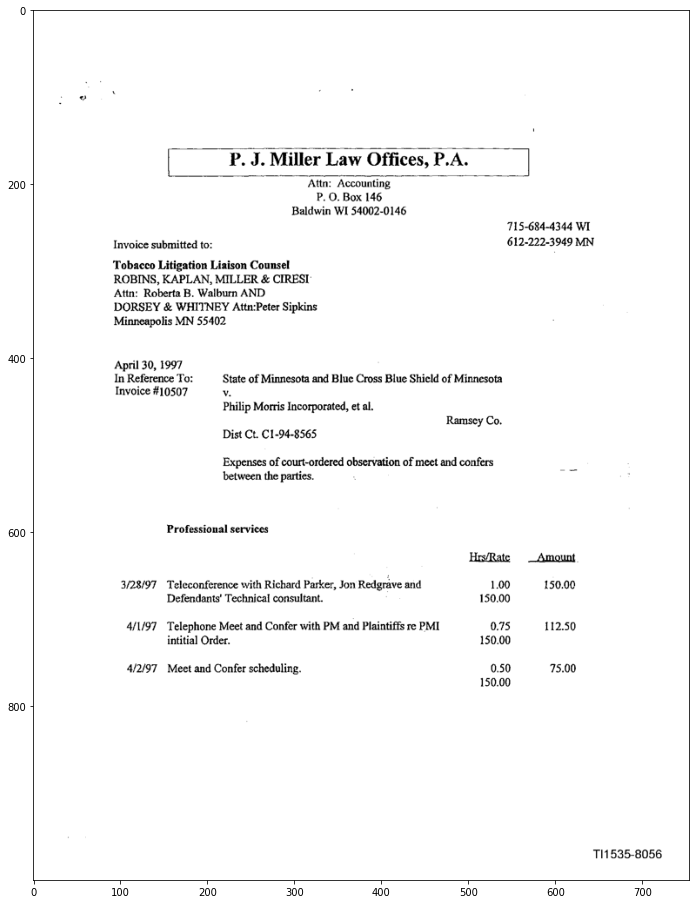

In [33]:
show_image(fn_)

In [34]:
reader = easyocr.Reader(['en'])
img_number = 1
dfr = pd.DataFrame(columns = ['image_id', ''])
img_ids_, results_ = list(), list()
len = []

for ix, fn_ in enumerate(dfs['tif']):
  print(ix, fn_)
  img_ids_.append(fn_.replace('.tif', ''))
  im = mpimg.imread(filepath + '/' + fn_)
  results_.append(reader.readtext(im))
  img_number +=1

0 ti16310260.tif
1 2028726871.tif
2 2070424009.tif
3 ti15358056_8057.tif
4 80233633.tif
5 2029370804.tif
6 2073684118.tif
7 0060053761.tif
8 2077000123.tif
9 2073883308.tif
10 2085540620.tif
11 ti16311156.tif
12 96063504.tif
13 2047260303.tif
14 2063846615.tif
15 2084022300.tif
16 2041158049.tif
17 1000031514.tif
18 0060060466.tif
19 2065216982.tif
20 83542445_2446.tif
21 2063610071.tif
22 2072957848.tif
23 93118029.tif
24 507053446.tif
25 506413423.tif
26 501149455.tif
27 0060060439.tif
28 92243549.tif
29 82867969.tif
30 86462803.tif
31 2071413111.tif
32 2063250015.tif
33 2080972555.tif
34 0060095738.tif
35 503918489+-8489.tif
36 2505123539_3542.tif
37 518029843_518029864.tif
38 2044348020.tif
39 518253689+-3695.tif
40 83644925.tif
41 00043445_00043449.tif
42 2071557502.tif
43 500125099+-5100.tif
44 2063322469.tif
45 2041597671_2041597672.tif
46 92185588.tif
47 92204693.tif
48 0013404965.tif
49 00921466.tif


In [36]:
dfr = pd.DataFrame({'image_id': img_ids_, 'result': results_})

In [37]:
dfr.head()

,image_id,result
0,ti16310260,"[([[203, 109], [281, 109], [281, 123], [203, 1..."
1,2028726871,"[([[590, 63], [653, 63], [653, 90], [590, 90]]..."
2,2070424009,"[([[211, 91], [279, 91], [279, 129], [211, 129..."
3,ti15358056_8057,"[([[222, 155], [498, 155], [498, 186], [222, 1..."
4,80233633,"[([[116, 114], [296, 114], [296, 144], [116, 1..."


In [35]:
def get_ocr_result(ocr_result, get, in_np_array=False):
  """
  get 'score', or 'bbox' (box position), or 'text'
  """
  getlist = ['bbox', 'text', 'score']
  getdict = {c:i for i,c in enumerate(getlist)}
  gd = getdict[get]
  get_result = [t[gd] for t in ocr_result]
  if in_np_array:
    get_result = np.array(get_result)
  return get_result

In [38]:
dfr['score'] = dfr['result'].apply(lambda x: get_ocr_result(x, 'score', True).mean())

In [39]:
dfr

,image_id,result,score
0,ti16310260,"[([[203, 109], [281, 109], [281, 123], [203, 1...",0.856269
1,2028726871,"[([[590, 63], [653, 63], [653, 90], [590, 90]]...",0.598472
2,2070424009,"[([[211, 91], [279, 91], [279, 129], [211, 129...",0.727107
3,ti15358056_8057,"[([[222, 155], [498, 155], [498, 186], [222, 1...",0.748132
4,80233633,"[([[116, 114], [296, 114], [296, 144], [116, 1...",0.749591
5,2029370804,"[([[13, 31], [91, 31], [91, 49], [13, 49]], Ma...",0.563411
6,2073684118,"[([[47, 73], [118, 73], [118, 97], [47, 97]], ...",0.788832
7,0060053761,"[([[13, 5], [35, 5], [35, 19], [13, 19]], Cc:,...",0.646548
8,2077000123,"[([[59, 81], [253, 81], [253, 97], [59, 97]], ...",0.635726
9,2073883308,"[([[281, 97], [465, 97], [465, 117], [281, 117...",0.655124


In [40]:
dfr['score'].mean()

0.6561603466445587

The raw data give us confidence score of around 65.6%

### Binarize
In layman’s terms **Binarization** means converting a coloured image into an image which consists of only black and white pixels (Black pixel value=0 and White pixel value=255). As a basic rule, this can be done by fixing a threshold (normally threshold=127, as it is exactly half of the pixel range 0–255). If the pixel value is greater than the threshold, it is considered as a white pixel, else considered as a black pixel.

Text(0.5, 1.0, 'Binarized Image')

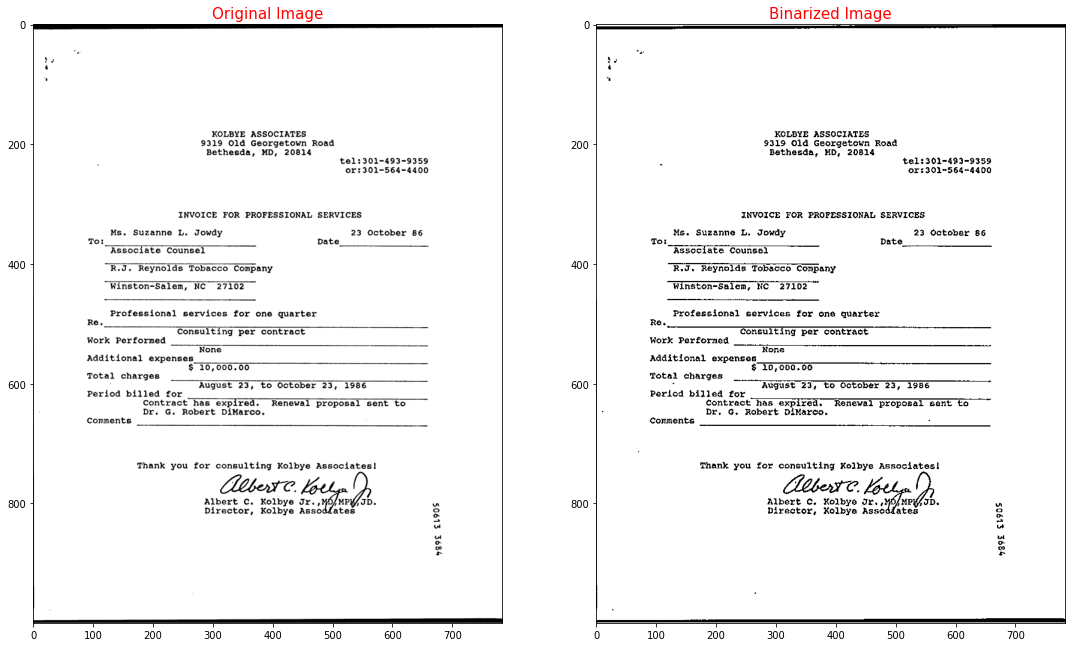

In [41]:
# binarize using adaptive threshold
fn1 = '506133684.tif'
fn1 = filepath + fn1

img1 = mpimg.imread(fn1)
f,ax = plt.subplots(1, 2, figsize=(18.5, 24))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title('Original Image', fontsize=15, color='red')

img1_binarize = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
ax[1].imshow(img1_binarize, cmap='gray')
ax[1].set_title('Binarized Image', fontsize=15, color='red')

Text(0.5, 1.0, 'Binarized Image')

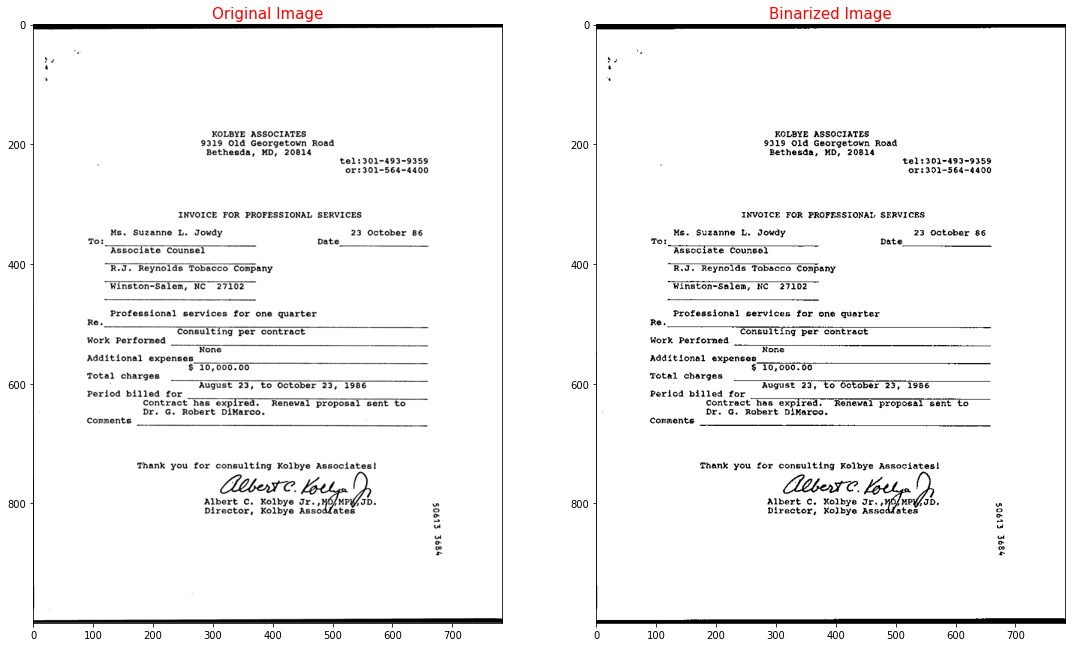

In [64]:
# binarize using OTSU threshold
fn1 = '506133684.tif'
fn1 = filepath + fn1

img1 = mpimg.imread(fn1)
f,ax = plt.subplots(1, 2, figsize=(18.5, 24))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title('Original Image', fontsize=15, color='red')

# gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img1_binarize = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

ax[1].imshow(img1_binarize, cmap='gray')
ax[1].set_title('Binarized Image', fontsize=15, color='red')

# gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
# thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

In [65]:
def show_2_images(img1, img2, fig_size=(18.5, 24), img_titles=['Image 1', 'Image 2']):
  f,ax = plt.subplots(1, 2, figsize=fig_size)
  ax[0].imshow(img1, cmap='gray')
  ax[0].set_title(img_titles[0], fontsize=15, color='red')
  ax[1].imshow(img2, cmap='gray')
  ax[1].set_title(img_titles[1], fontsize=15, color='red')
  plt.show()
  return None

In [66]:
def binarize(image):
  image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
  return image

In [69]:
fn2 = '83542445_2446.tif'
img2 = mpimg.imread(filepath + fn2)
img2_binarize = binarize(img2)
# img2_binarize = cv2.bitwise_not(img2_binarize)

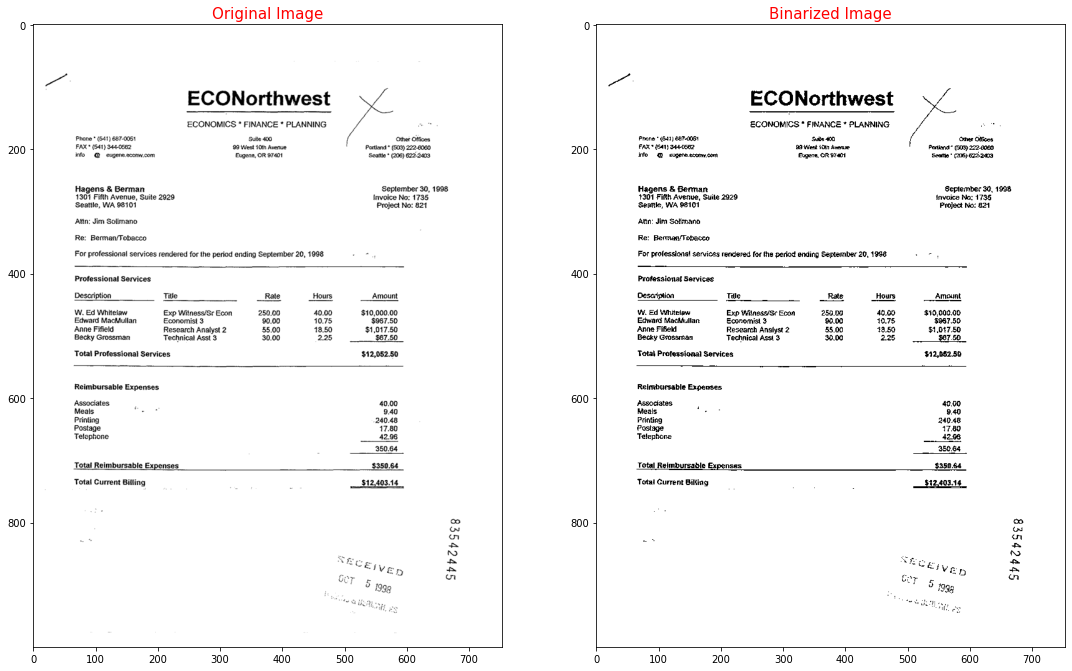

In [70]:
show_2_images(img2, img2_binarize, img_titles=['Original Image', 'Binarized Image'])

In [71]:
for i in dfs['tif']:
  fn = filepath + i
  img_ = mpimg.imread(fn)
  img_binarize_ = binarize(img_)
  fn_save = filepath + 'temp/' + i.replace('.tif', '_binarize.tif')
  cv2.imwrite(fn_save, img_binarize_)

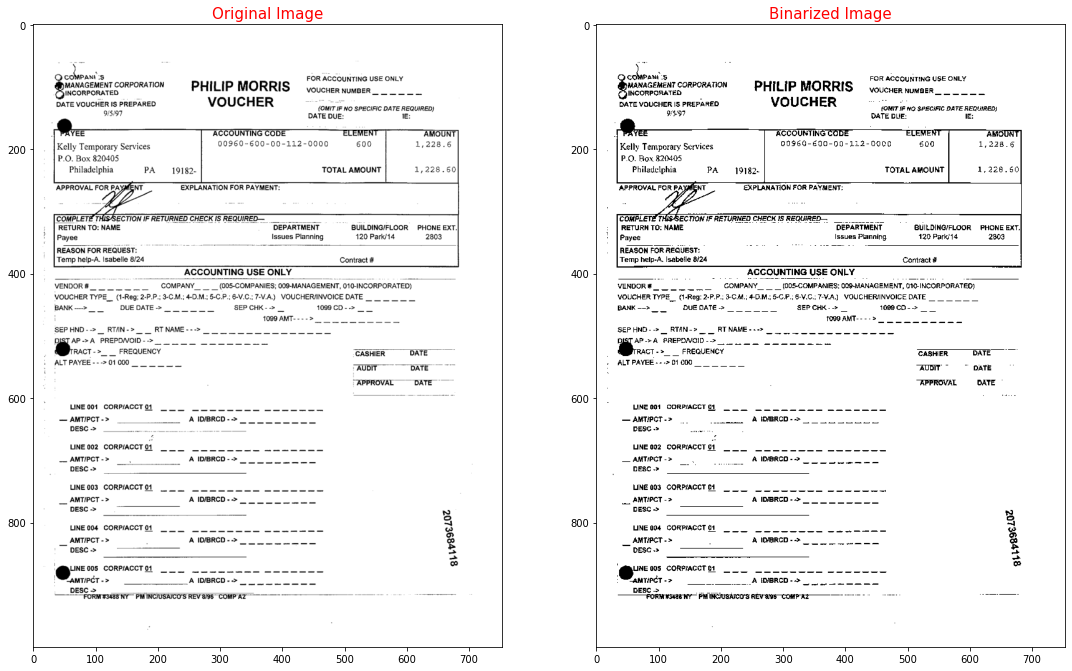

In [78]:
fn = dfs['tif'].values[6]
img = mpimg.imread(filepath + fn)
fn = temp_path + dfs['tif'].values[6].replace('.tif', '_binarize.tif')
img_binarize = mpimg.imread(fn)

show_2_images(img, img_binarize, img_titles=['Original Image', 'Binarized Image'])

**Preprocessed image above give us a better contrast of the text. However, the font appear to be thicker which is not the best case because it's a bit harder to differentiate each characters due to thickness of the font.**

In [ ]:
dfr.head()

,image_id,result,score
0,ti16310260,"[([[203, 109], [281, 109], [281, 123], [203, 1...",0.851138
1,2028726871,"[([[590, 63], [653, 63], [653, 90], [590, 90]]...",0.599066
2,2070424009,"[([[211, 91], [279, 91], [279, 129], [211, 129...",0.737226
3,ti15358056_8057,"[([[222, 155], [498, 155], [498, 186], [222, 1...",0.762517
4,80233633,"[([[116, 114], [296, 114], [296, 144], [116, 1...",0.747684


In [73]:
def read_ocr(data=dfs, column='tif', ocr_reader=reader, path=filepath, process=None):
  img_ids_, results_ = [], []
  for ix, fn_ in enumerate(data['tif']):
    print(ix, fn_)
    img_ids_.append(fn_.replace('.tif', ''))
    if process is not None:
      fn_ = fn_.replace('.tif', '_' + process + '.tif')
    im = mpimg.imread(path + '/' + fn_)
    results_.append(reader.readtext(im))
  dfres = pd.DataFrame({'image_id': img_ids_, 'result': results_})
  return dfres

In [74]:
#binarize
# dfr1 = read_ocr(data=dfs, column='tif', ocr_reader=reader, path=temp_path, process='binarize')

In [ ]:
# ll = lambda x: get_ocr_result(x, 'score', True).mean()
# dfr1['score'] = dfr1['result'].apply(ll)

In [ ]:
# dfr1['score'].mean()

0.5366468637950783

### Skew Correction
While scanning a document, it might be slightly skewed (image aligned at a certain angle with horizontal) sometimes. While extracting the information from the scanned image, detecting & correcting the skew is crucial.


In [79]:
from scipy.ndimage import interpolation as inter

In [80]:
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        # histogram, score = determine_score(thresh, angle)
        histogram, score = determine_score(image, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return best_angle, corrected

In [81]:
fn

'/content/text-extraction-for-ocr/ImageAndXML_Data/temp/2073684118_binarize.tif'

In [82]:
angle, img_rotated = correct_skew(img_binarize)

In [83]:
angle

0

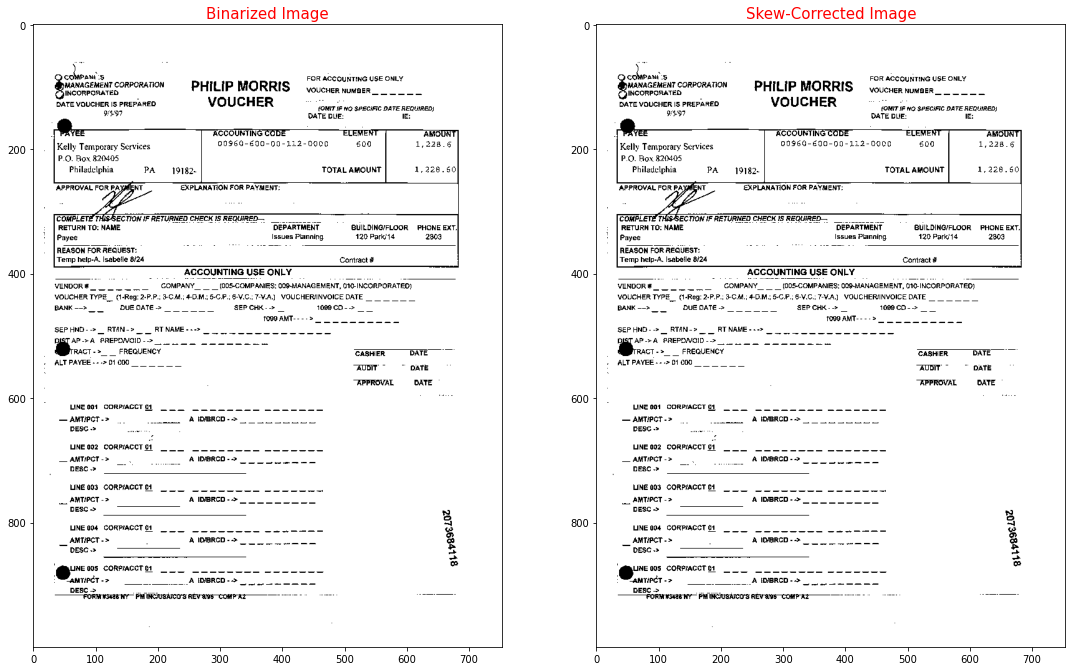

In [85]:
show_2_images(img_binarize, img_rotated, img_titles=['Binarized Image', 'Skew-Corrected Image'])

The image above, does not in fact need a skew correction because it's already in the correct angle

In [86]:
# performing skew correction image to all sample images
angles = []
fns = []

for i in dfs['tif']:
  i = i.replace('.tif', '_binarize.tif')
  fn_ = temp_path + i
  img_ = mpimg.imread(fn_)
  fns.append(i)
  angle_, img_rotate_ = correct_skew(img_)
  angles.append(angle_)
  fn_save = filepath + 'temp/' + i.replace('_binarize.tif', '_rotated.tif')
  cv2.imwrite(fn_save, img_rotate_)

In [87]:
# check rotated image
{k:c for c,k in zip(angles, fns) if c != 0}

{'2029370804_binarize.tif': -1,
 'ti16311156_binarize.tif': -1,
 '93118029_binarize.tif': -1,
 '507053446_binarize.tif': 1,
 '2080972555_binarize.tif': -1,
 '2041597671_2041597672_binarize.tif': -1,
 '92204693_binarize.tif': -1}

Most Image only rotated at max. ±1°

In [88]:
fn = '2029370804.tif'
img = mpimg.imread(filepath + fn)
img_binarize = mpimg.imread(temp_path + fn.replace('.tif', '_binarize.tif'))
img_rotate = mpimg.imread(temp_path + fn.replace('.tif', '_rotated.tif'))

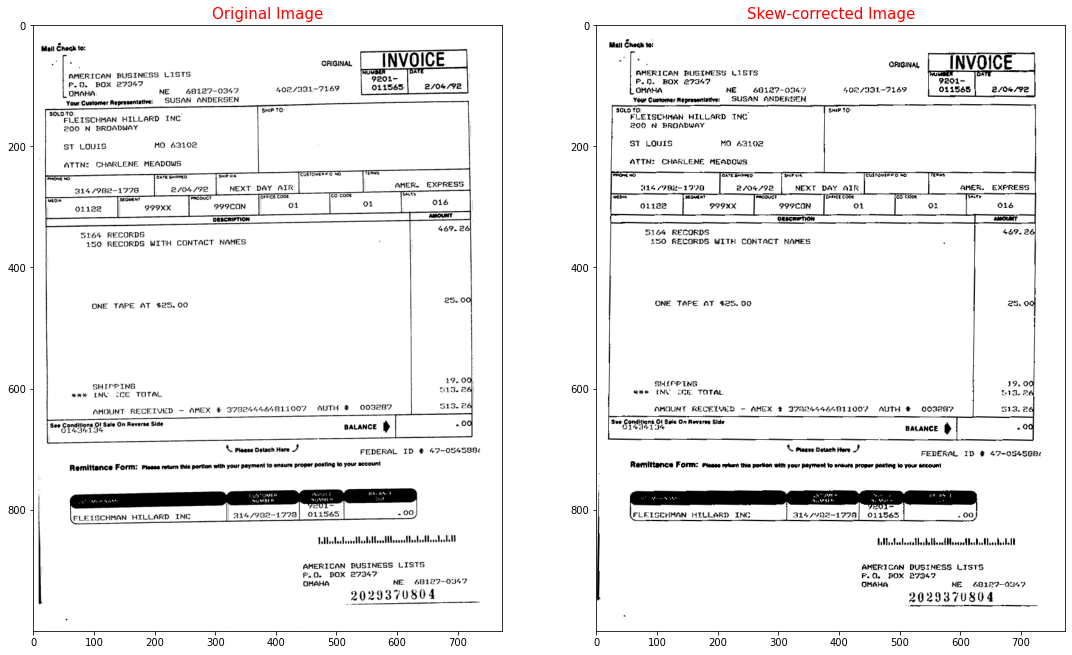

In [89]:
show_2_images(img, img_rotate, fig_size=(18.5, 24), img_titles=['Original Image', 'Skew-corrected Image'])

### [Morphological Transformations](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html)
Morphological transformations are some simple operations based on the image shape. It is normally performed on binary images. It needs two inputs, one is our original image, second one is called structuring element or kernel which decides the nature of operation. Two basic morphological operators are Erosion and Dilation. Then its variant forms like Opening, Closing, Gradient etc also comes into play.




In [95]:
def noise_removal(image, kz=(1,1), blur=3):
  kernel = np.ones(kz, np.uint8)
  image = cv2.dilate(image, kernel, iterations=1)
  image = cv2.erode(image, kernel, iterations=1)
  image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
  image = cv2.medianBlur(image, blur)
  return image

In [121]:
img_noise_remove = noise_removal(img_rotate, blur=2)
img_noise_remove1 = noise_removal(img, blur=2)

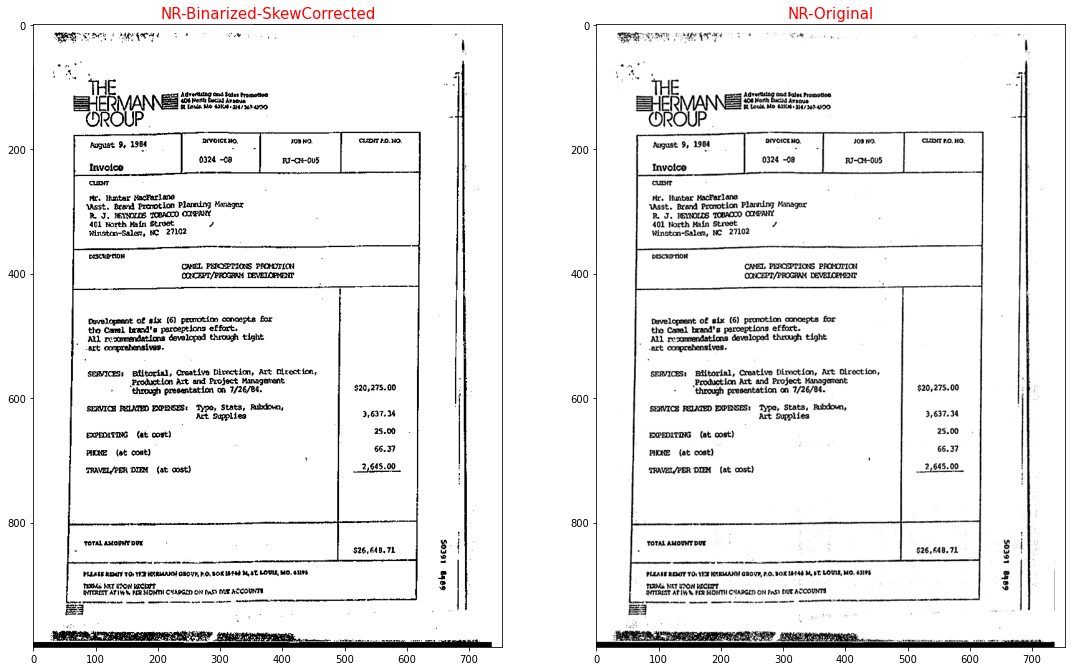

In [122]:
show_2_images(img_noise_remove, img_noise_remove1, fig_size=(18.5, 24), img_titles=['NR-Binarized-SkewCorrected', 'NR-Original'])

In [104]:
dfs.sample(n=5, random_state=1)

,ids,tif,ocr,gt,size,shape,height,width
27,0060060439,0060060439.tif,0060060439_ocr.xml,0060060439_gt.xml,762000,"(1000, 762)",1000,762
35,503918489+-8489,503918489+-8489.tif,503918489+-8489_ocr.xml,503918489+-8489_gt.xml,754000,"(1000, 754)",1000,754
40,83644925,83644925.tif,83644925_ocr.xml,83644925_gt.xml,754000,"(1000, 754)",1000,754
38,2044348020,2044348020.tif,2044348020_ocr.xml,2044348020_gt.xml,799000,"(1000, 799)",1000,799
2,2070424009,2070424009.tif,2070424009_ocr.xml,2070424009_gt.xml,754000,"(1000, 754)",1000,754


In [105]:
fn = '503918489+-8489.tif'
img = mpimg.imread(filepath + fn)
img_binarize = mpimg.imread(temp_path + fn.replace('.tif', '_binarize.tif'))
img_rotate = mpimg.imread(temp_path + fn.replace('.tif', '_rotated.tif'))

In [106]:
img_noise_remove = noise_removal(img_rotate, blur=1)
img_noise_remove1 = noise_removal(img, blur=1)

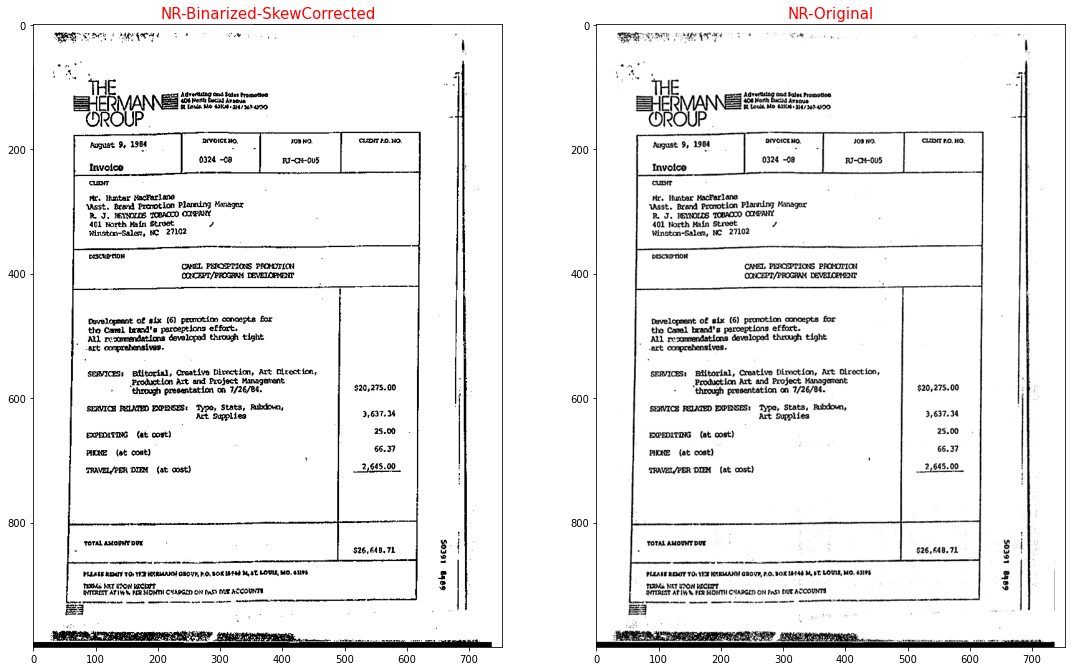

In [108]:
show_2_images(img_noise_remove, img_noise_remove1, fig_size=(18.5, 24), img_titles=['NR-Binarized-SkewCorrected', 'NR-Original'])